# Point Clouds from Stereo images


Following libraries need to be installed to run this notebook:
numpy, cv2, matplotlib, jupyterlab

In [1]:
import numpy as np
import cv2
import glob
import argparse
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
'''
The function merges point coordinates with colors and write them as a point cloud.

source: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
'''

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def create_ply(vertices, colors,fname):
    colors = colors.reshape(-1, 3)
    vertices = np.hstack([vertices.reshape(-1, 3), colors])
    with open(fname, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(vertices))).encode('utf-8'))
        np.savetxt(f, vertices, fmt='%f %f %f %d %d %d ')



def downsample_image(image, scaling_factor):
    h,w = image.shape[:2]
    height_resize, width_resize = int(h/scaling_factor), int(w/scaling_factor)
    image = cv2.resize(image, (width_resize, height_resize))
    return image


In [3]:
right_ims = 'data/SonyA7/Scene/right/DSC*.JPG'
left_ims = 'data/SonyA7/Scene/left/DSC*.JPG'

left_images = glob.glob(left_ims)
left_images.sort()
right_images = glob.glob(right_ims)
right_images.sort()
right_images

['data/SonyA7/Scene/right\\DSC00062.JPG',
 'data/SonyA7/Scene/right\\DSC00063.JPG',
 'data/SonyA7/Scene/right\\DSC00064.JPG',
 'data/SonyA7/Scene/right\\DSC00065.JPG',
 'data/SonyA7/Scene/right\\DSC00066.JPG',
 'data/SonyA7/Scene/right\\DSC00067.JPG',
 'data/SonyA7/Scene/right\\DSC00068.JPG',
 'data/SonyA7/Scene/right\\DSC00069.JPG',
 'data/SonyA7/Scene/right\\DSC00070.JPG',
 'data/SonyA7/Scene/right\\DSC00071.JPG',
 'data/SonyA7/Scene/right\\DSC00072.JPG',
 'data/SonyA7/Scene/right\\DSC00073.JPG',
 'data/SonyA7/Scene/right\\DSC00074.JPG',
 'data/SonyA7/Scene/right\\DSC00075.JPG']

## Remapping stereo image pairs

In [4]:
cv_file = cv2.FileStorage()
cv_file.open('data/OpenCV_Calibrations/stereoMap_Sony_A7_14.06.2023.xml', cv2.FileStorage_READ)

stereoMapL_x = cv_file.getNode('stereoMapL_x').mat()
stereoMapL_y = cv_file.getNode('stereoMapL_y').mat()
stereoMapR_x = cv_file.getNode('stereoMapR_x').mat()
stereoMapR_y = cv_file.getNode('stereoMapR_y').mat()
Q = cv_file.getNode('q').mat() # 'q' or 'Q' depending on how the file is built
Q

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.68508472e+03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -3.91953839e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.03797266e+03],
       [ 0.00000000e+00,  0.00000000e+00,  4.65820920e+00,
         0.00000000e+00]])

In [5]:
for i in range(len(right_images)):
    right = cv2.imread(right_images[i])
    h,w = right.shape[:2]
    left = cv2.imread(left_images[i])

    right_remapped = cv2.remap(right, stereoMapR_x, stereoMapR_y, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    left_remapped = cv2.remap(left, stereoMapL_x, stereoMapL_y, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

    gray_left_remapped = cv2.cvtColor(left_remapped, cv2.COLOR_BGR2GRAY)
    gray_right_remapped = cv2.cvtColor(right_remapped, cv2.COLOR_BGR2GRAY)

    right_remapped = downsample_image(right_remapped,4)
    left_remapped = downsample_image(left_remapped,4)
    gray_left_remapped = downsample_image(gray_left_remapped,4)
    gray_right_remapped = downsample_image(gray_right_remapped,4)
    
    dir_str_l = 'data/remapped/SonyA7/left/remapped_left_'+str(right_images[i][-7:-4]) + '.jpg'
    dir_str_r = 'data/remapped/SonyA7/right/remapped_right_'+str(right_images[i][-7:-4]) + '.jpg'

    cv2.imwrite(dir_str_l, left_remapped)
    cv2.imwrite(dir_str_r, right_remapped)
    '''
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
    ax1.imshow(left)
    ax2.imshow(left_remapped)
    '''

# Disparity Map generation

In [6]:
right_rms = 'data/remapped/SonyA7/right/*.jpg'
left_rms = 'data/remapped/SonyA7/left/*.jpg'

right_images_remapped = glob.glob(right_rms)
left_images_remapped = glob.glob(left_rms)
right_images_remapped.sort()
left_images_remapped.sort()

right_images_remapped[-1][-6:-4], left_images_remapped[-1][-6:-4]

('75', '75')

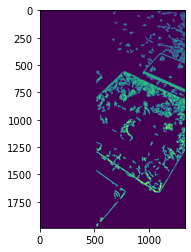

In [7]:
stereo = cv2.StereoSGBM_create(numDisparities = 512, blockSize = 5, speckleWindowSize = 200, speckleRange = 1)
for i in range(len(right_images_remapped)):

    gray_left_remapped = cv2.imread(left_images_remapped[i], cv2.IMREAD_GRAYSCALE)
    gray_right_remapped = cv2.imread(right_images_remapped[i], cv2.IMREAD_GRAYSCALE)

    disparity_map = stereo.compute(gray_left_remapped, gray_right_remapped)

# Normalize the values to a range from 0..255 for a grayscale image
    disparity_norm = cv2.normalize(disparity_map, disparity_map, alpha=255,
                                    beta=0, norm_type=cv2.NORM_MINMAX)
    disparity_norm = np.uint8(disparity_norm)
    plt.imshow(disparity_norm)
#cv2.imshow("Disparity", disparity_SGBM)
    dir_map = 'data/disparity_maps/disparity_'+str(left_images_remapped[i][-7:-4]) + '.png'
    dir_norm = 'data/disparity_maps/norm_u8/disparity_norm_'+str(left_images_remapped[i][-7:-4]) + '.png'
    cv2.imwrite(dir_map, disparity_map)
    cv2.imwrite(dir_norm, disparity_norm)

# Point Cloud Generation

According to the OpenCV [documentation](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02), the function that projects disparity map to 3D requires 8-bit unsigned, 16-bit signed, 32-bit signed or 32-bit floating-point disparity image. However, 16-bit signed disparities computed by block-matching algorithms should be divided by 16 and converted to float. 

In [8]:
disps_fn = "data/disparity_maps/*.png"
disps_remapped = glob.glob(disps_fn)
disps_remapped.sort()
disps_remapped[-1]

'data/disparity_maps\\disparity_075.png'

In [9]:
for i in range(len(disps_remapped)):
    imgL = cv2.imread(left_images_remapped[i]) 
    imgR = cv2.imread(right_images_remapped[i])

    disparity_map = cv2.imread(disps_remapped[i], cv2.IMREAD_GRAYSCALE)
    disparity_map = np.float32(np.divide(disparity_map, 16.0))
    h,w = imgR.shape[:2]

    # Reproject points into 3D
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q, handleMissingValues=False)
    # Get color of the reprojected points
    colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)

    # Filtering points with value 0 (no depth)
    mask_map = disparity_map > disparity_map.min()

    # Mask colors and points. 
    output_points = points_3D[mask_map]
    output_colors = colors[mask_map]
    
    pc_dir = 'data/pcs/pointcloud_'+str(left_images_remapped[i][-7:-4])+'.ply'


    # Generate point cloud file
    create_ply(output_points, output_colors, pc_dir)
    